# Lineal Regresion

*Oliver Mazariegos  -  16043*

Se crece lambda cuando hay variance
Para hacer esto se ploteo el J(trainint) y J(test)d contra 

## Carga de paquetes, funciones y dataset

In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

In [158]:
def linear_cost (X,
                 y,
                 theta,
                 la_lambda):
    return ((np.matmul(X, theta)-y)**2).sum()*(1/2*X.shape[0])  + (theta ** 2).sum()*(la_lambda/2*X.shape[0])

def linear_cost_derivate(X,
                         y,
                         theta,
                         la_lambda):
    return np.matmul((np.matmul(X, theta)-y).T,X).T.sum()/X.shape[0] + theta.sum()*la_lambda/X.shape[0]

def gradient_descent(
    X,
    y,
    theta_0,
    cost,
    cost_derivate,
    alpha=0.001,
    la_lambda=0.0001,
    treshold=0.0001,
    max_iter=10000):
    costs = []
    gradient_norms = []
    theta, i = theta_0, 0
    while np.linalg.norm(cost_derivate(X,y,theta,alpha)) > treshold and i <max_iter:
        theta = theta - (alpha * cost_derivate(X,y,theta,alpha))
        i +=1
        costs.append(cost(X, y, theta,alpha))
        gradient_norms.append(cost_derivate(X, y, theta, alpha))
    return theta, costs, gradient_norms


In [159]:
data = pd.read_csv('Admission_Predict.csv')

## Análisis exploratorio del dataset

### Heatmap para todas las variables simples

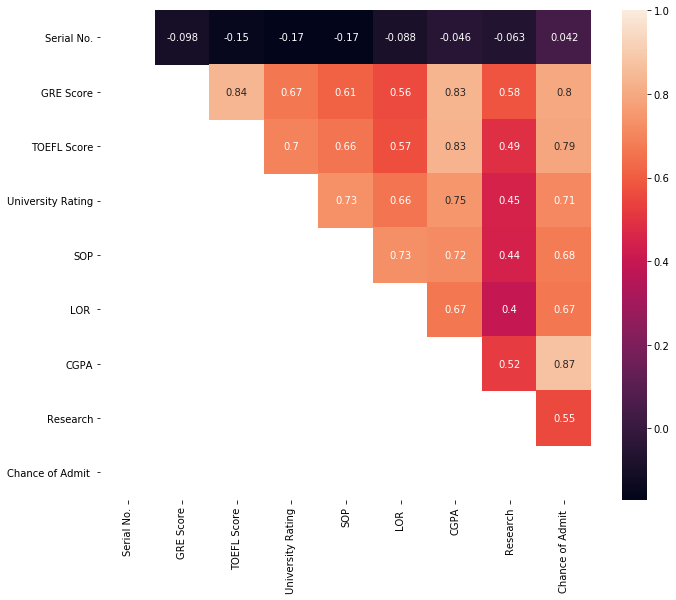

In [160]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# triangulo inferior de la matriz
matrix = np.tril(data.corr())
# heatmap
sns.heatmap(data.corr(), annot=True, mask=matrix)
plt.show()


En el gráfico anterior se ve que las variables que más se relacionan con `Chance of Admit` son `CGPA`, `GRE Score`, `TOEFL Score`. Aunque el `University Rating`, `SOP` y `LOR` tambien tienen una relacion pero no tan alta.

### Heatmap para todas las variables al cuadrado

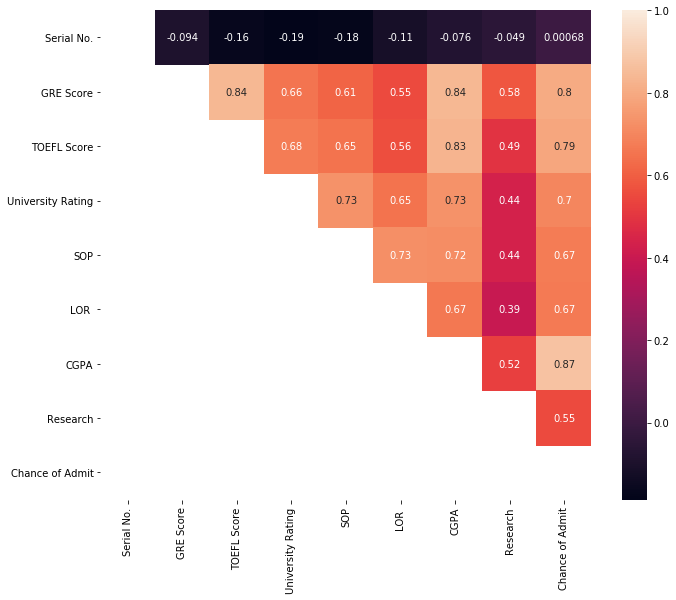

In [161]:
data2 = data.iloc[:,:-1] ** 2
data2['Chance of Admit'] = data['Chance of Admit ']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# triangulo inferior de la matriz
matrix = np.tril(data2.corr())
# heatmap
sns.heatmap(data2.corr(), annot=True, mask=matrix)
plt.show()



En el heatmap de correlacion con las variables elevadas al cuadrado se puede ver que la relación no cambia mucho por lo que considero que no es necesario agregar alguna variable elevada al cuadrado en el modelo final.

## Graficos entre variables

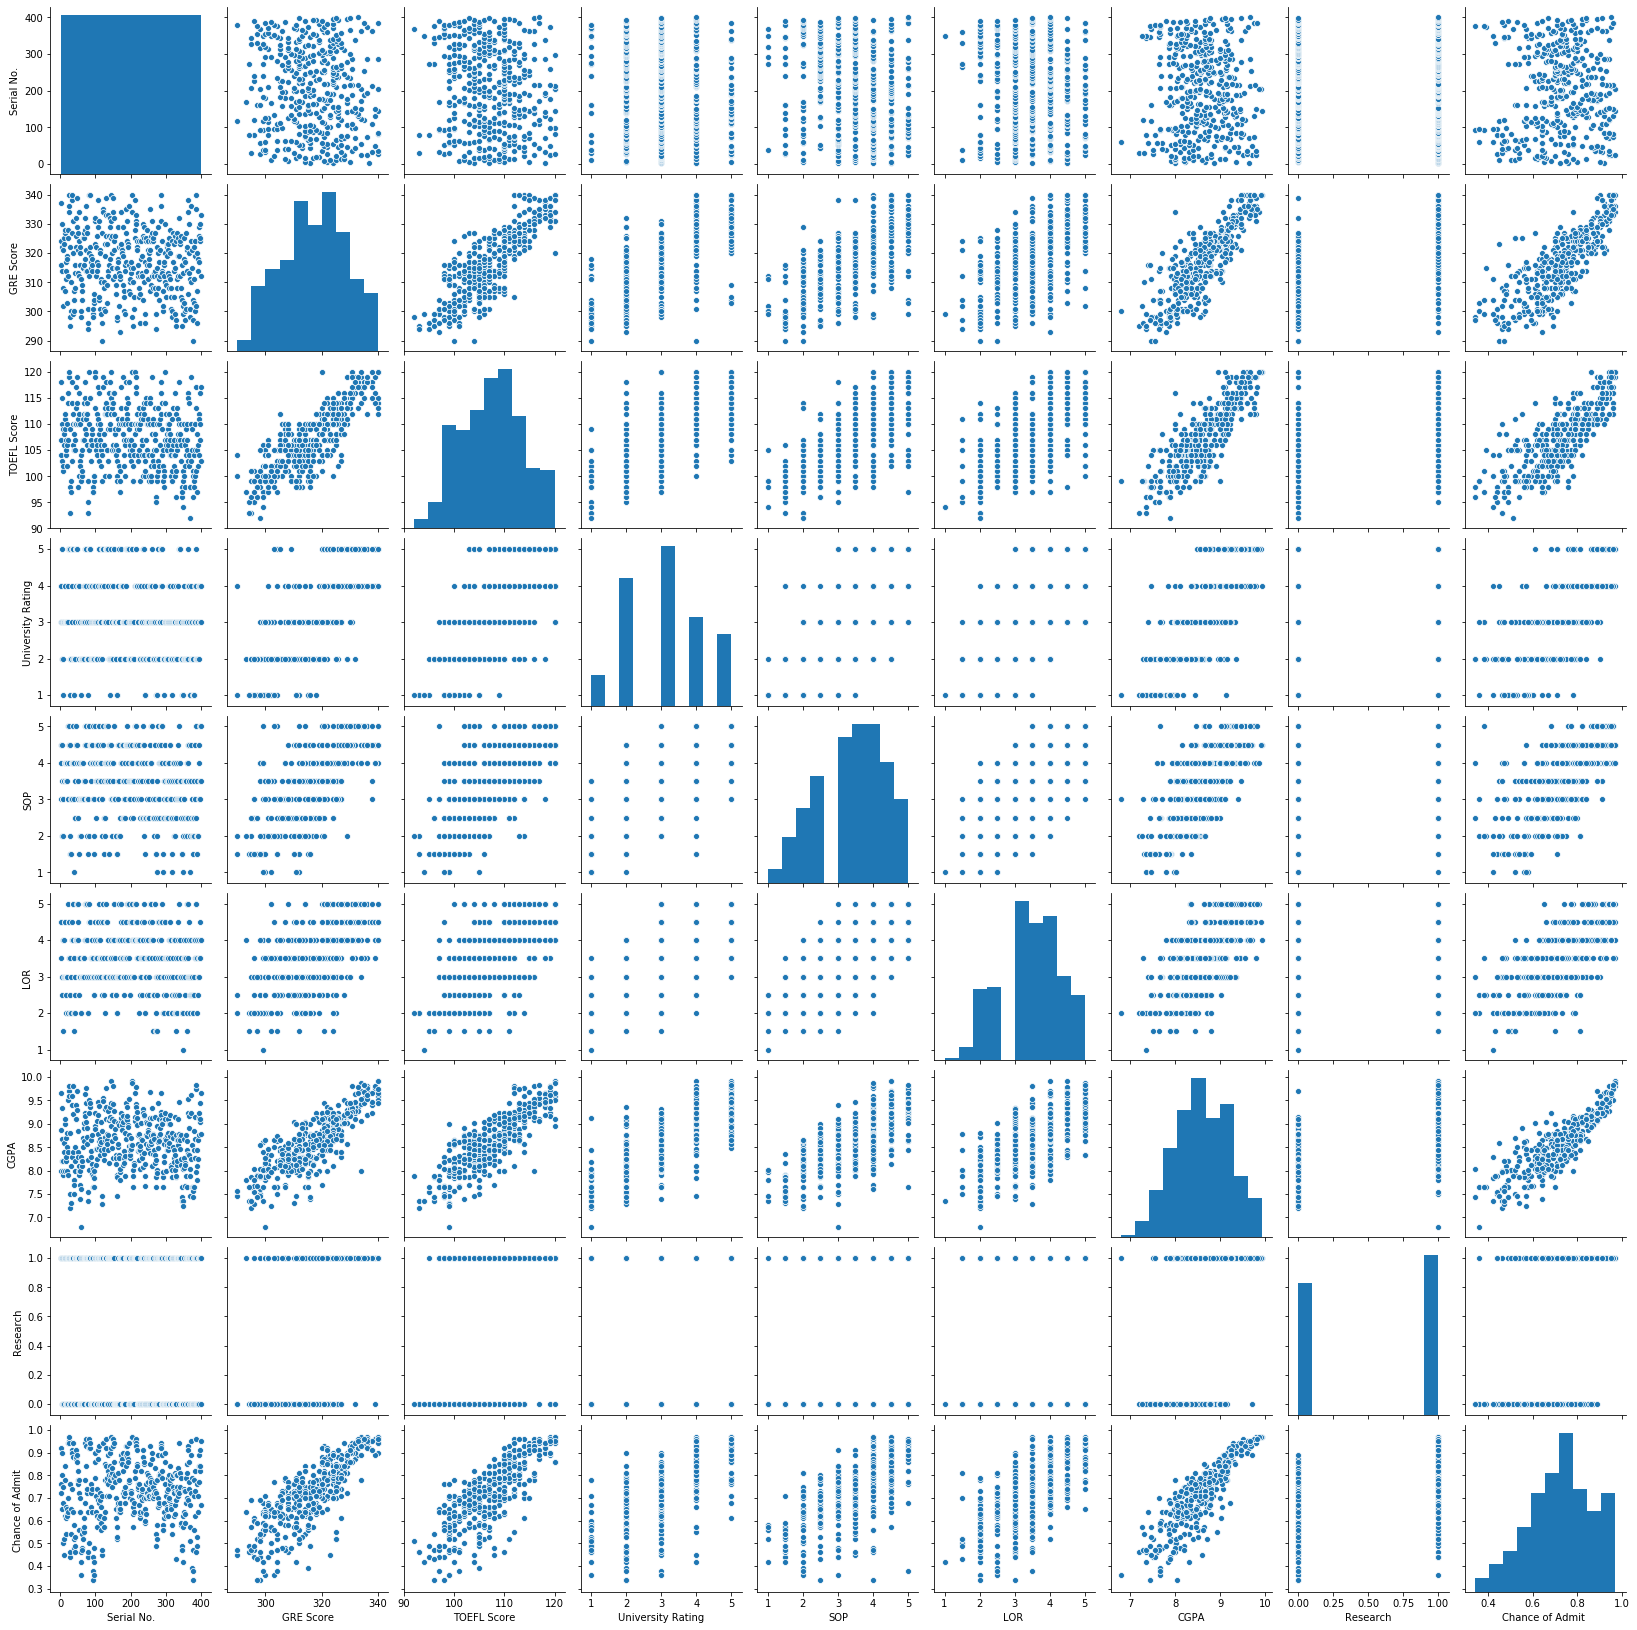

In [162]:
sns.pairplot(data)
plt.show()

Con ayuda del gráfico anterior vamos a definir con que variables nos quedaremos para realizar el modelo y que variables desecharemos. Empecemos con `Serial No.` que es una variable que no aporta nada en el dataset mas que enumerar las filas del dataset, `Serial No.` será descartado. `Research` es otra variable que no tiene una fuerte relacion con nuestra variable objetivo y ademas es categórica por lo cual tampoco la tomaremos en cuenta. `LOR`, `SOP` y `University Rating` pareciera que tienen una relación con `Chance of Admit ` pero por ser categoricas tal vez sería mejor transformarlas, más adelante las multiplicaremos entre ellas y veremos su relacion con nuestra variable objetivo. Las que si utilizaremos porque se ve una alta relacion lineal es `CGPA`, `GRE` y `TOEFL`. 

### Multiplicando LOR , SOP y Rating

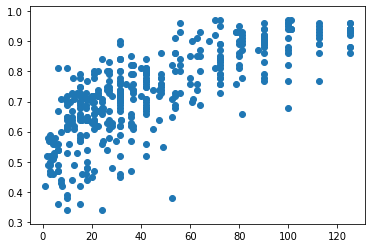

In [163]:
lorSop = data['LOR '] * data['SOP'] * data['University Rating']
plt.scatter(lorSop,data['Chance of Admit '])


El grafico anterior me muestra que la multiplicación entre `LOR `, `SOP` y `University Rating` tienen mejor relacion con `Chance of Admit` que ellas por si solas. 

In [164]:
lorSopRating = data['LOR '] * data['SOP'] * data['University Rating']
data3 = pd.DataFrame({'lorSopRating':lorSop,'Chance of Admit ': data['Chance of Admit ']})
data3.corr()

,lorSopRating,Chance of Admit
lorSopRating,1.000000,0.749028
Chance of Admit,0.749028,1.000000


## Propuesta 1

La primer propuesta para generar el modelo es con 4 variables. `GRE`, `TOEFL`, `CGPA` y `LOR * SOP * University Rating`.

In [165]:
modelo1 = pd.DataFrame({'GRE Score':data['GRE Score'],'TOEFL Score': data['TOEFL Score'],'CGPA': data['CGPA'],'SOP-LOR-RATING': lorSopRating, 'Chance of Admit ': data['Chance of Admit ']})

In [166]:
modelo1.corr()

,GRE Score,TOEFL Score,CGPA,SOP-LOR-RATING,Chance of Admit
GRE Score,1.000000,0.835977,0.833060,0.665612,0.802610
TOEFL Score,0.835977,1.000000,0.828417,0.686213,0.791594
CGPA,0.833060,0.828417,1.000000,0.770228,0.873289
SOP-LOR-RATING,0.665612,0.686213,0.770228,1.000000,0.749028
Chance of Admit,0.802610,0.791594,0.873289,0.749028,1.000000


In [167]:
modelo1.insert(0,'ones',list(np.ones(400)))

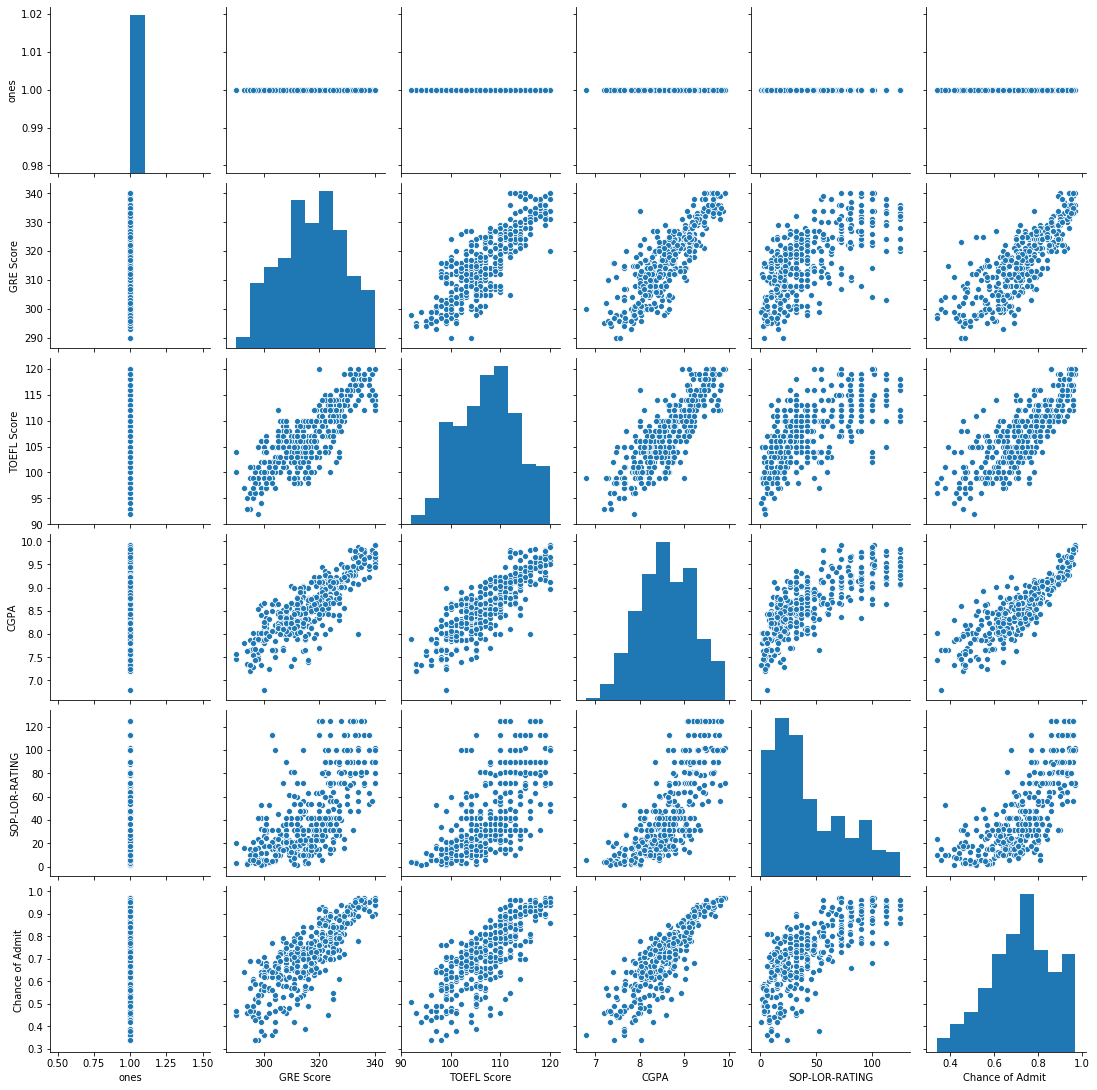

In [168]:
sns.pairplot(modelo1)

### Training, cross validation y test set

In [169]:
X_train, X_test, y_train, y_test = train_test_split(modelo1.iloc[:,:-1], modelo1.iloc[:,-1], test_size=0.4)
X_cross, X_test, y_cross, y_test = train_test_split(X_test,y_test,test_size=0.5)
X_train = X_train.values
y_train = y_train.values.reshape(240,1)
X_cross = X_cross.values
y_cross = y_cross.values.reshape(80,1)
X_test = X_test.values
y_test = y_test.values.reshape(80,1)
print( X_train.shape, y_train.shape )
print( X_cross.shape, y_cross.shape )
print( X_test.shape, y_test.shape )

(240, 5) (240, 1)
(80, 5) (80, 1)
(80, 5) (80, 1)


### Decenso del Gradiente

In [170]:
m, n = X_train.shape
theta_0 = np.random.rand(n, 1)
theta, costs, gradient_norms = gradient_descent(
    X_train,
    y_train,
    theta_0,
    linear_cost,
    linear_cost_derivate,
    alpha=0.0000001,
    la_lambda=0.00001,
    treshold=0.001,
    max_iter=10000
)

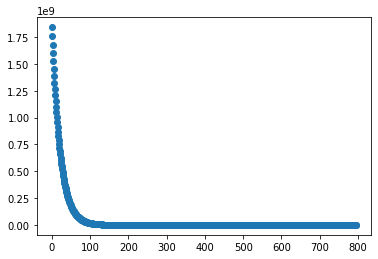

In [171]:
plt.scatter(list(range(0,len(costs))),costs)

#### Costo con el cross validation set

In [172]:
linear_cost(X_cross,y_cross,theta,0.00001)

238644.87971092077

El costo es demasiado alto! para disminuir el costo intentare a reducir el numero de features a tomar en cuenta para realizar el modelo.

## Propuesta 2

Debido a que `GRE`, `TOEFL` y `CGPA` tienen mucha relacion entre ellos probare multiplicarlos entre ellos para tomarlos como una sola variable en vez de 3.

In [173]:
greToeflCgpa = data['GRE Score'] * data['TOEFL Score'] * data['CGPA']
data3 = pd.DataFrame({'lorSop':greToeflCgpa,'Chance of Admit ': data['Chance of Admit ']})
data3.corr()

,lorSop,Chance of Admit
lorSop,1.000000,0.875338
Chance of Admit,0.875338,1.000000


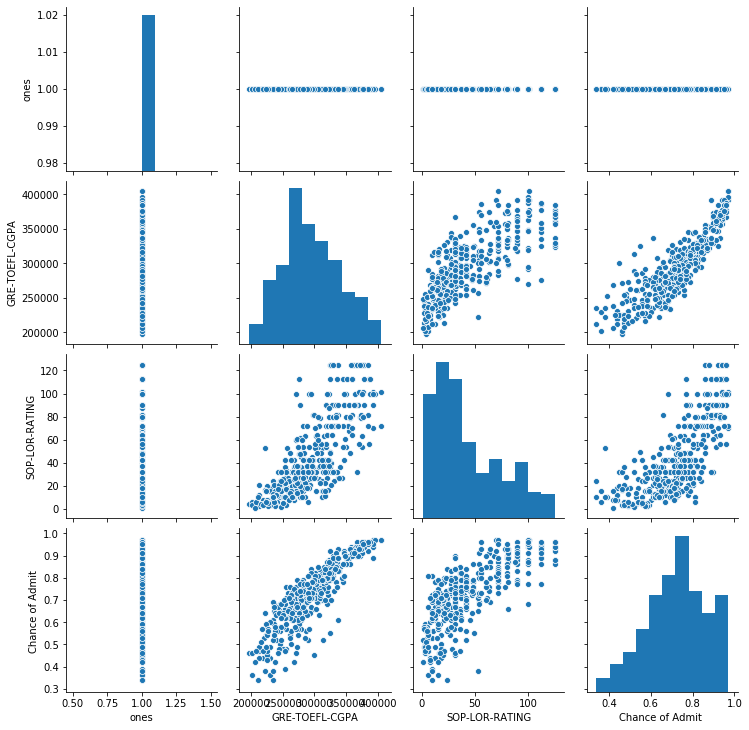

In [174]:
greToeflCgpa = data['GRE Score'] * data['TOEFL Score'] * data['CGPA']
modelo2 = pd.DataFrame({'GRE-TOEFL-CGPA':greToeflCgpa,'SOP-LOR-RATING': lorSopRating,'Chance of Admit ': data['Chance of Admit ']})
modelo2.insert(0,'ones',list(np.ones(400)))
sns.pairplot(modelo2)

Pareciera que logramos poder reducir todas las tres variables continuas a una sola conservando la relacion con la variable predictora. Veamos como se ve la convinacion de features con respecto al `Chance of Admit`.

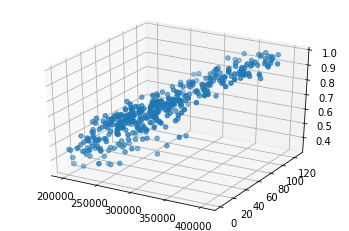

In [175]:
ax = plt.axes(projection='3d')
ax.scatter3D(modelo2['GRE-TOEFL-CGPA'], modelo2['SOP-LOR-RATING'], modelo2['Chance of Admit ']);

Pareciera como si se pudiera dibujar una linea en el espacio tri dimensional de nuestro modelo por lo que se espera un costo menor que con el de la propuesta 1.

### Train, cross validation y test set

In [176]:
X_train, X_test, y_train, y_test = train_test_split(modelo2.iloc[:,:-1], modelo2.iloc[:,-1], test_size=0.4)
X_cross, X_test, y_cross, y_test = train_test_split(X_test,y_test,test_size=0.5)
X_train = X_train.values
y_train = y_train.values.reshape(240,1)
X_cross = X_cross.values
y_cross = y_cross.values.reshape(80,1)
X_test = X_test.values
y_test = y_test.values.reshape(80,1)
print( X_train.shape, y_train.shape )
print( X_cross.shape, y_cross.shape )
print( X_test.shape, y_test.shape )

(240, 3) (240, 1)
(80, 3) (80, 1)
(80, 3) (80, 1)


## Decenso del gradiente

In [177]:
m, n = X_train.shape
theta_0 = np.random.rand(n, 1)
theta, costs, gradient_norms = gradient_descent(
    X_train,
    y_train,
    theta_0,
    linear_cost,
    linear_cost_derivate,
    alpha=0.00000000001,
    la_lambda=0.99,
    treshold=0.00001,
    max_iter=10000000
)

#### Cross Validation

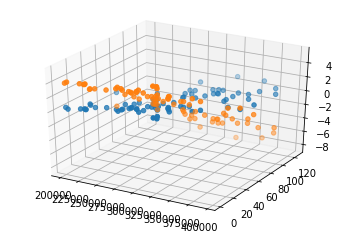

In [178]:
ax = plt.axes(projection='3d')
ax.scatter3D(list(X_cross[:,1]), list(X_cross[:,2]), list(y_cross))
ax.scatter3D(list(X_cross[:,1]), list(X_cross[:,2]), np.matmul(X_cross,theta))

In [179]:
linear_cost(X_cross,y_cross,theta,0.00001)

32243.164043670866

A pesar de que la grafica de nuestro modelo mostrara que mejoraria nuestra regresion lineal los costos aun están muy altos. Apesar de que el costo sigue alto, el costo disminuyo considerablemente con el del modelo de la primera propuesta.

### propuesta 3

Debido al alto costo del modelo anterior removeré las variables categoricas que en este caso seria `SOP-LOR-RATING` y me quedare solo con las numericas en la forma de `GRE-TOEFL-CGPA`.

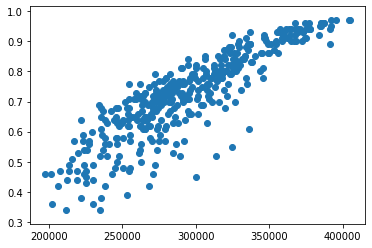

In [188]:
modelo3 = pd.DataFrame({'GRE-TOEFL-CGPA':greToeflCgpa,'Chance of Admit ': data['Chance of Admit ']})
modelo3.insert(0,'ones',list(np.ones(400)))
plt.scatter(modelo3['GRE-TOEFL-CGPA'],modelo3['Chance of Admit '])

In [189]:
X_train, X_test, y_train, y_test = train_test_split(modelo3.iloc[:,:-1], modelo3.iloc[:,-1], test_size=0.4)
X_cross, X_test, y_cross, y_test = train_test_split(X_test,y_test,test_size=0.5)
X_train = X_train.values
y_train = y_train.values.reshape(240,1)
X_cross = X_cross.values
y_cross = y_cross.values.reshape(80,1)
X_test = X_test.values
y_test = y_test.values.reshape(80,1)
print( X_train.shape, y_train.shape )
print( X_cross.shape, y_cross.shape )
print( X_test.shape, y_test.shape )

(240, 2) (240, 1)
(80, 2) (80, 1)
(80, 2) (80, 1)


In [190]:
m, n = X_train.shape
theta_0 = np.random.rand(n, 1)
theta, costs, gradient_norms = gradient_descent(
    X_train,
    y_train,
    theta_0,
    linear_cost,
    linear_cost_derivate,
    alpha=0.0000000000001,
    la_lambda=0.8,
    treshold=0.001,
    max_iter=100000
)

#### Cross Validation

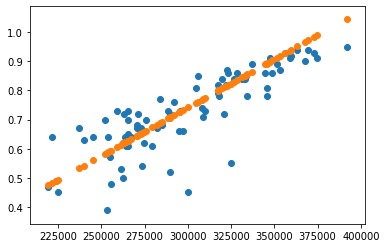

In [191]:
plt.scatter(X_cross[:,1],y_cross)
plt.scatter(X_cross[:,1],np.matmul(X_cross,theta))

In [192]:
linear_cost(X_cross,y_cross,theta,0.8)

22.969499278689344

En la gráfica del cross validation pareciera que tenemos un modelo que es muy cercano a la realidad y hemos logrado el menor costo entre las tres propuestas. Considero que este es el modelo a utilizar.

### Costo real con Test Set

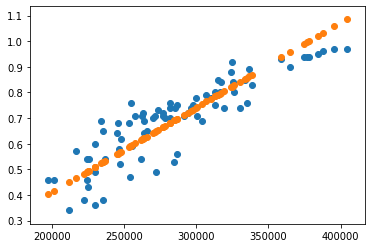

In [193]:
plt.scatter(X_test[:,1],y_test)
plt.scatter(X_test[:,1],np.matmul(X_test,theta))

In [194]:
linear_cost(X_test,y_test,theta,0.8)

20.666328937543994

Con el test set tambien se obtiene un costo muy bajo y en la gráfica se puede ver que nos acercamos mucho a la realidad. Considero que este es el modelo adecuado.

## Conclusion
El mejor modelo obtuvido es de una sola feature de la forma $ y = \theta_0 + \theta_{1}X_1 $ donde $ X_1 $ es la multiplicación de GRE, TOEFL y CGPA; y los theta son:

In [195]:
theta

array([[-2.52627003e-01],
       [ 3.31416851e-06]])